# Coarse grained (high-dimensional residues)

Parameters:

* $c$ -- cutoff distance for pair of atoms
* $b$ -- number of bins for distance between two residues
* $a$ -- number of bins for angles
* $n$ -- number of neighbouring residues to skip

In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn
from multiprocessing import Pool, TimeoutError
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize, MaxAbsScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  BayesianRidge, ElasticNet, Ridge)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from data_mining import *

In [2]:
mat_file_patterns = []

for num_dof in [4]:
    for num_dist_bins in [6, 8, 10, 12, 14]:
        for num_angle_bins in [4, 6, 9, 12, 15]:
            for cutoff in [0, 3, 5, 7, 10, 15, 20]:
                for neighbourhood in [0, 1, 2]:
                    mat_file_patterns.append(
                        '*residues-d{}-b{}-a{}-c{}-n{}--skip_errors.mat'.format(
                            num_dof, num_dist_bins, num_angle_bins, cutoff, neighbourhood
                        )
                    )

In [3]:
checksums = ['8269eab4b9ebaa69aa1467308c48ed4f']

In [4]:
def get_natives(scores):
    natives = np.array([bool(re.match('T0...\.pdb', x.split('/')[-1])) for x in scores.index])
    return pd.Series(data=natives, index=scores.index)

In [5]:
models = [
    ("Normalizer + Ridge",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(normalize=False, fit_intercept=False, solver='sparse_cg'))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X)),
    ("MaxAbsScaler + Ridge",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(normalize=False, fit_intercept=False, solver='sparse_cg'))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X))
]

In [7]:
scores = load_pickled_dataset(dataset_binary_filename(mat_file_patterns[3], checksums[0], 'binaries'))[1]
scores = select_subset(scores, scores, '^.*CASP([5-9]|10)/T..../.*$')[1]
indices = scores.index.sort_values().copy()

In [8]:
results_train = {}
results_val = {}

In [9]:
def compute_results(args):
    try:
        mat_file_pattern, indices = args

        for checksum in checksums:
            try:
                X, scores, _ = load_pickled_dataset(
                    dataset_binary_filename(mat_file_pattern, checksum, 'binaries')
                )
                break
            except:
                X, scores = None, None

        if X is None:
            print(mat_file_pattern, '\tError: Dataset not found', flush=True)
            return mat_file_pattern, None

        scores['__temp_index'] = range(scores.shape[0])
        scores = scores.loc[indices]
        if pd.isnull(scores['__temp_index']).sum():
            print(mat_file_pattern, '\tError: Got smaller dataset', flush=True)
            return mat_file_pattern, None

        X = X[scores['__temp_index'].values]
        del scores['__temp_index']

        old_shape = X.shape
        X, nonzero_features = remove_zero_features(X)
        print(mat_file_pattern, '\tX.size: {},\t{} -> {}'.format(X.size, old_shape, X.shape), flush=True)

        train_blocks, train_idx, val_blocks, val_idx = train_test_split(one_hot_from_scores(scores),
                                                                        test_ratio=0.4, seed=17)
        X_train = X[train_idx]
        X_val = X[val_idx]
        del X
        scores_train = scores[train_idx]
        scores_val = scores[val_idx]

        results_train = {}
        results_val = {}

        for model_name, model, train, predicted_score in models:

            ### Train
            train(model, X_train, scores[train_idx])

            ### Results on training set
            results_train[model_name + ' + native'], _ = scoring_results(X_train, scores_train,
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)

            results_train[model_name], _ = scoring_results(X_train[~get_natives(scores_train).values],
                                                           scores_train[~get_natives(scores_train).values],
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)
            ### Results on validation set
            results_val[model_name + ' + native'], _ = scoring_results(X_val, scores_val,
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

            results_val[model_name], _ = scoring_results(X_val[~get_natives(scores_val).values],
                                                         scores_val[~get_natives(scores_val).values],
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

        return mat_file_pattern, (results_train, results_val)
    except Exception as e:
        print(mat_file_pattern, '\tError: Exception', e, flush=True)
        return mat_file_pattern, None

In [176]:
pool = Pool(processes=16)
pool_result = pool.imap_unordered(compute_results, [(mat_file_pattern, indices)
                                       for mat_file_pattern in mat_file_patterns
                                       if mat_file_pattern not in results_train.keys()])
pool.close()

*residues-d4-b6-a4-c3-n1--skip_errors.mat 	Error: Dataset not found
*residues-d4-b6-a4-c3-n2--skip_errors.mat 	Error: Dataset not found
*residues-d4-b6-a4-c7-n1--skip_errors.mat 	Error: Dataset not found


In [187]:
returned = []

try:
    while True:
        returned.append(pool_result.next(timeout=0))
except TimeoutError:
    print('Timeout')
except StopIteration:
    print('Done')

for mat_file_pattern, res in returned:
    if res:
        results_train[mat_file_pattern], results_val[mat_file_pattern] = res

len(returned), len([x for x in returned if x[1]])

Done


(0, 0)

## Test

In [19]:
params = ['b', 'a', 'c', 'n']

In [20]:
def mean_top1_score(scores):
    return scores['GDT-TS-score']['Mean score for top 1']

def correlation_score(scores):
    return -scores['GDT-TS-score'][['Mean Pearson', 'Mean Spearman']].mean()

def summary(results):
    records = []
    for quality_criterion in [mean_top1_score, correlation_score]:
        for model in sorted(list(results.items())[0][1].keys()):
            benchmark = generate_benchmark(results, quality_criterion)
            best_dataset = benchmark[model].argmax()
            records.append((best_dataset,
                            model + ' + ' + quality_criterion.__name__,
                            results[best_dataset][model]['GDT-TS-score']))
    df = pd.concat([x[2] for x in records], axis=1)
    df.columns = [x[1] for x in records]
    df.loc['The best dataset'] = [x[0] for x in records]
    return df

def plot_results(results, model, quality_criterion, params, **kwargs):
    benchmark = generate_benchmark(results, quality_criterion)
    plot_heatmaps(benchmark, model, params, **kwargs)

    print('The best:\n{}'.format(benchmark[model].argmax()))
    display(results[benchmark[model].argmax()][model])

In [188]:
df = summary(results_val)
display(df.iloc[:, [c.split(' + ')[-2] == 'native' for c in df.columns]].T)
display(df.iloc[:, [c.split(' + ')[-2] != 'native' for c in df.columns]].T)

Mean rank of the native  \
MaxAbsScaler + Ridge + native + mean_top1_score                   70.0575   
Normalizer + Ridge + native + mean_top1_score                     32.4558   
MaxAbsScaler + Ridge + native + correlation_score                 66.2611   
Normalizer + Ridge + native + correlation_score                   28.0664   

                                                       Top 1     Top 5  \
MaxAbsScaler + Ridge + native + mean_top1_score    0.0265487  0.128319   
Normalizer + Ridge + native + mean_top1_score       0.283186  0.433628   
MaxAbsScaler + Ridge + native + correlation_score  0.0353982  0.123894   
Normalizer + Ridge + native + correlation_score     0.190265  0.393805   

                                                  Mean score for top 1  \
MaxAbsScaler + Ridge + native + mean_top1_score               0.484077   
Normalizer + Ridge + native + mean_top1_score                 0.679733   
MaxAbsScaler + Ridge + native + correlation_score             0.480354   
Normalizer + Ridge + native + correlation_score               0.622746   

                                                  Mean loss score  \
MaxAbsScaler + Ridge + native + mean_top1_score          0.515923   
Normalizer + Ridge + native + mean_top1_score            0.320267   
MaxAbsScaler + Ridge + native + correlation_score        0.519646   
Normalizer + Ridge + native + correlation_score          0.377254   

                                                  Mean Pearson Mean Spearman  \
MaxAbsScaler + Ridge + native + mean_top1_score      -0.239307      -0.18612   
Normalizer + Ridge + native + mean_top1_score        -0.559218     -0.450573   
MaxAbsScaler + Ridge + native + correlation_score    -0.251849     -0.202776   
Normalizer + Ridge + native + correlation_score      -0.579326     -0.468992   

                                                  Mean Kendall tau      PMCC  \
MaxAbsScaler + Ridge + native + mean_top1_score          -0.127189 -0.325559   
Normalizer + Ridge + native + mean_top1_score            -0.320655 -0.662652   
MaxAbsScaler + Ridge + native + correlation_score         -0.13845 -0.338657   
Normalizer + Ridge + native + correlation_score          -0.334224 -0.677246   

                                                       SMCC    wmPMCC  \
MaxAbsScaler + Ridge + native + mean_top1_score   -0.310564 -0.258245   
Normalizer + Ridge + native + mean_top1_score     -0.668619 -0.615934   
MaxAbsScaler + Ridge + native + correlation_score -0.339344  -0.26972   
Normalizer + Ridge + native + correlation_score   -0.684599 -0.632494   

                                                     wmSMCC Mean Z-score  \
MaxAbsScaler + Ridge + native + mean_top1_score   -0.198471     0.293626   
Normalizer + Ridge + native + mean_top1_score     -0.478113       2.1112   
MaxAbsScaler + Ridge + native + correlation_score -0.215227     0.281127   
Normalizer + Ridge + native + correlation_score   -0.493721      1.60094   

                                                                              The best dataset  
MaxAbsScaler + Ridge + native + mean_top1_score      *residues-d4-b6-a4-c0-n1--skip_errors.mat  
Normalizer + Ridge + native + mean_top1_score       *residues-d4-b10-a4-c3-n0--skip_errors.mat  
MaxAbsScaler + Ridge + native + correlation_score    *residues-d4-b6-a4-c0-n2--skip_errors.mat  
Normalizer + Ridge + native + correlation_score    *residues-d4-b10-a12-c5-n0--skip_errors.mat

Mean rank of the native       Top 1  \
MaxAbsScaler + Ridge + mean_top1_score                    118.92  0.00442478   
Normalizer + Ridge + mean_top1_score                     81.2611   0.0132743   
MaxAbsScaler + Ridge + correlation_score                 121.611           0   
Normalizer + Ridge + correlation_score                   80.4646   0.0176991   

                                              Top 5 Mean score for top 1  \
MaxAbsScaler + Ridge + mean_top1_score    0.0265487             0.470539   
Normalizer + Ridge + mean_top1_score      0.0619469             0.529939   
MaxAbsScaler + Ridge + correlation_score  0.0176991               0.4555   
Normalizer + Ridge + correlation_score    0.0840708             0.513763   

                                         Mean loss score Mean Pearson  \
MaxAbsScaler + Ridge + mean_top1_score          0.169638    -0.226135   
Normalizer + Ridge + mean_top1_score            0.110238    -0.568124   
MaxAbsScaler + Ridge + correlation_score        0.184677    -0.238434   
Normalizer + Ridge + correlation_score          0.126414    -0.575526   

                                         Mean Spearman Mean Kendall tau  \
MaxAbsScaler + Ridge + mean_top1_score       -0.182013        -0.124211   
Normalizer + Ridge + mean_top1_score         -0.457523        -0.324968   
MaxAbsScaler + Ridge + correlation_score     -0.198736        -0.135344   
Normalizer + Ridge + correlation_score       -0.465058        -0.330819   

                                              PMCC      SMCC    wmPMCC  \
MaxAbsScaler + Ridge + mean_top1_score   -0.323569  -0.30831 -0.245721   
Normalizer + Ridge + mean_top1_score     -0.662034 -0.667854 -0.623275   
MaxAbsScaler + Ridge + correlation_score -0.336302 -0.337123 -0.257104   
Normalizer + Ridge + correlation_score   -0.676664 -0.683464 -0.631114   

                                            wmSMCC Mean Z-score  \
MaxAbsScaler + Ridge + mean_top1_score   -0.194197     0.190704   
Normalizer + Ridge + mean_top1_score     -0.482821     0.555114   
MaxAbsScaler + Ridge + correlation_score -0.210891    0.0743268   
Normalizer + Ridge + correlation_score    -0.48976     0.423686   

                                                                     The best dataset  
MaxAbsScaler + Ridge + mean_top1_score      *residues-d4-b6-a4-c0-n1--skip_errors.mat  
Normalizer + Ridge + mean_top1_score       *residues-d4-b6-a15-c5-n0--skip_errors.mat  
MaxAbsScaler + Ridge + correlation_score    *residues-d4-b6-a4-c0-n2--skip_errors.mat  
Normalizer + Ridge + correlation_score    *residues-d4-b10-a12-c5-n0--skip_errors.mat

### Regression

#### Row normalization

##### Mean score for top 1

plot_results(results_val,
             'Normalizer + Ridge', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score

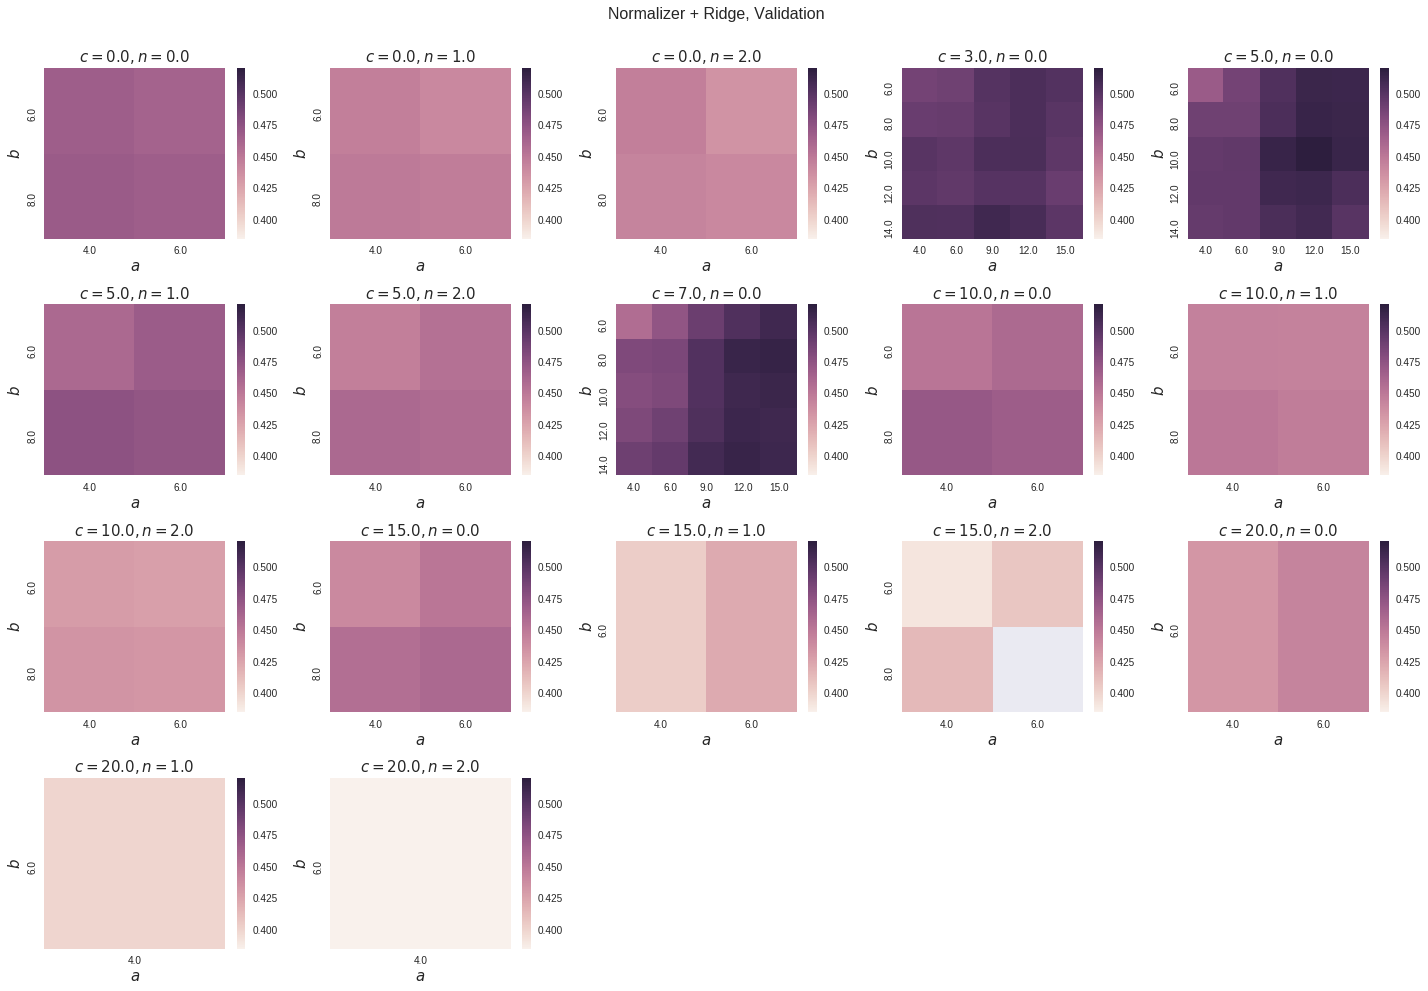

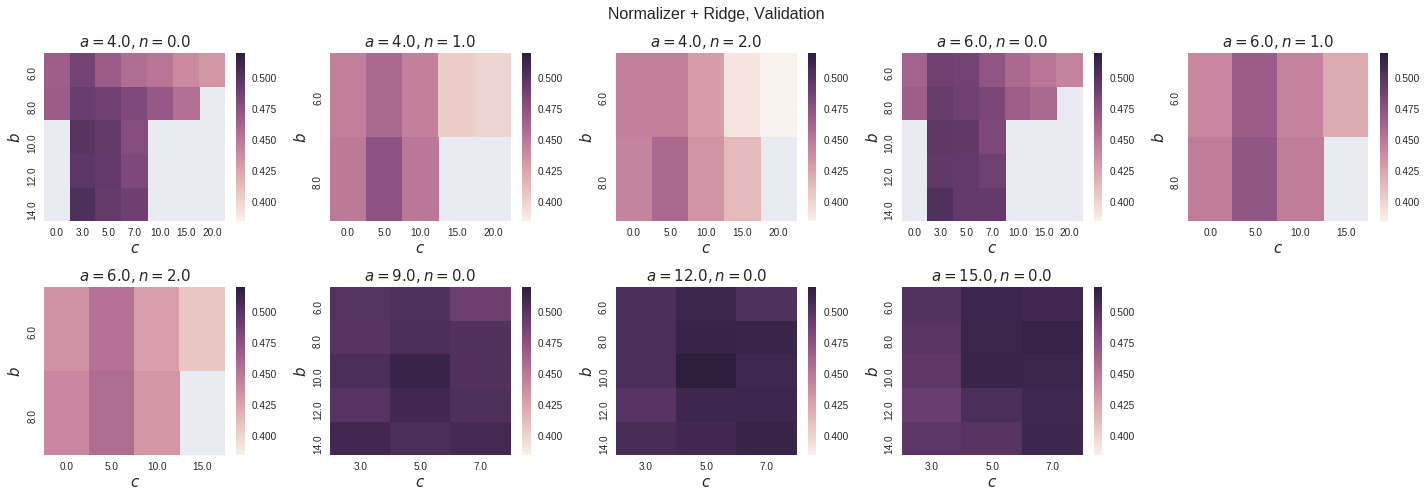

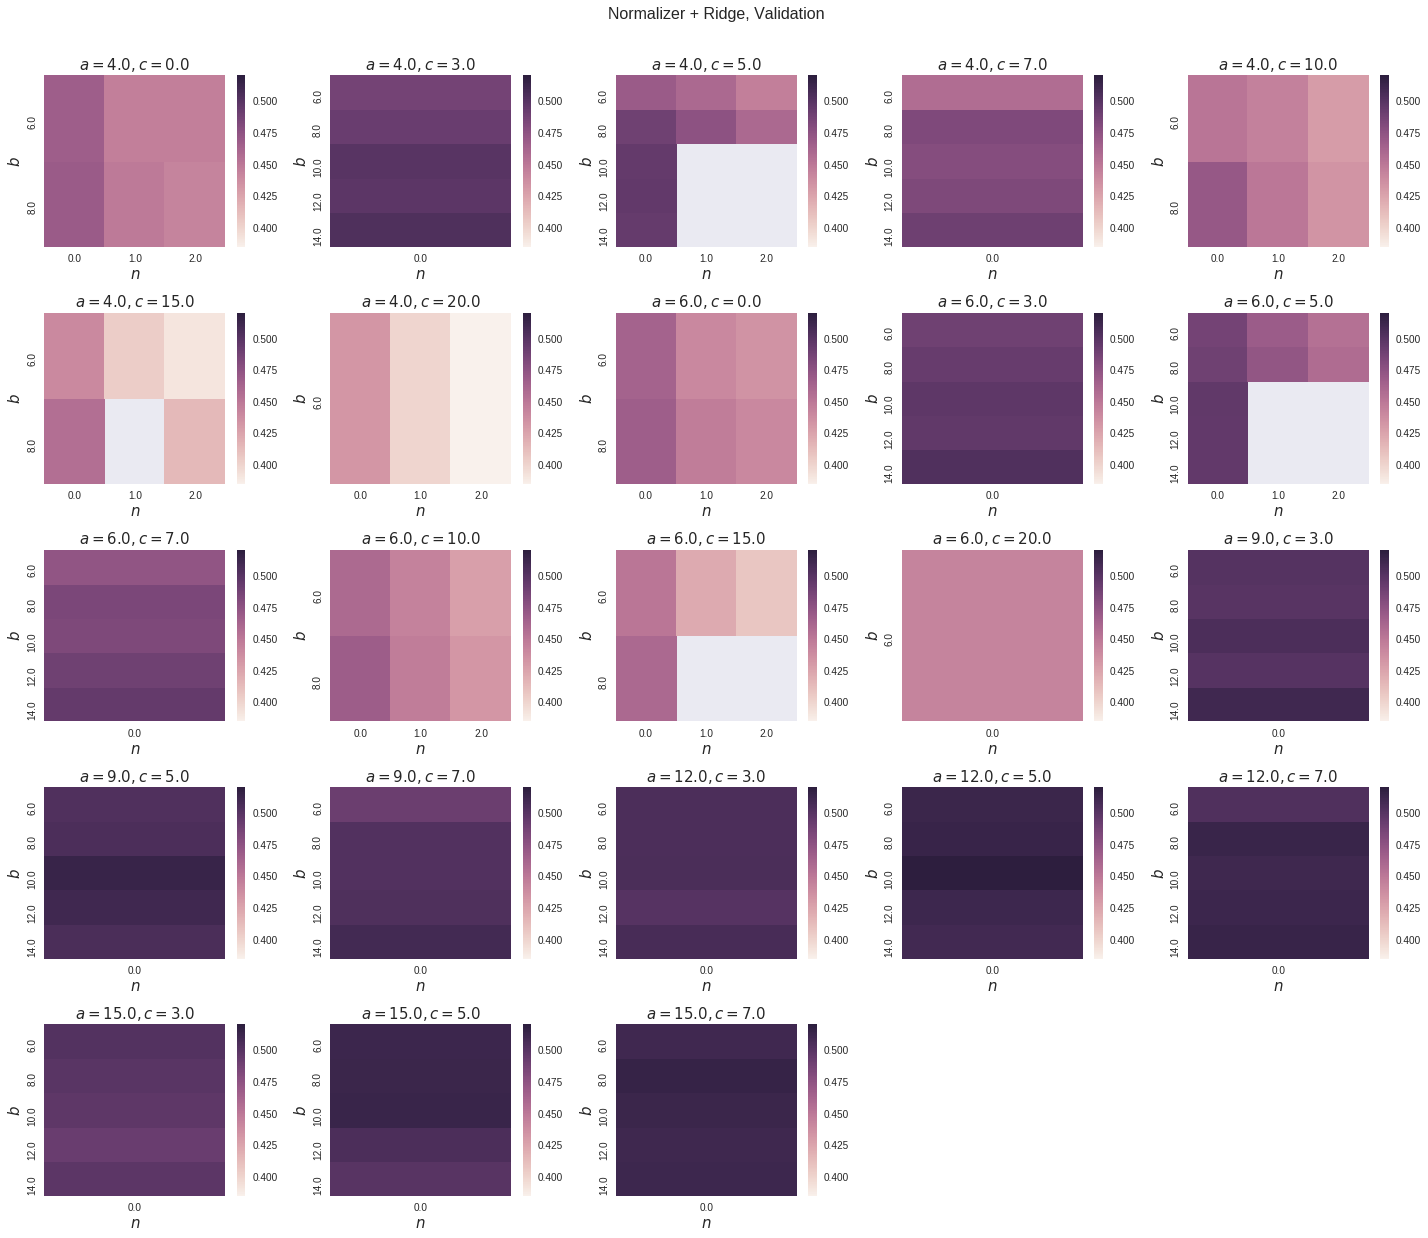

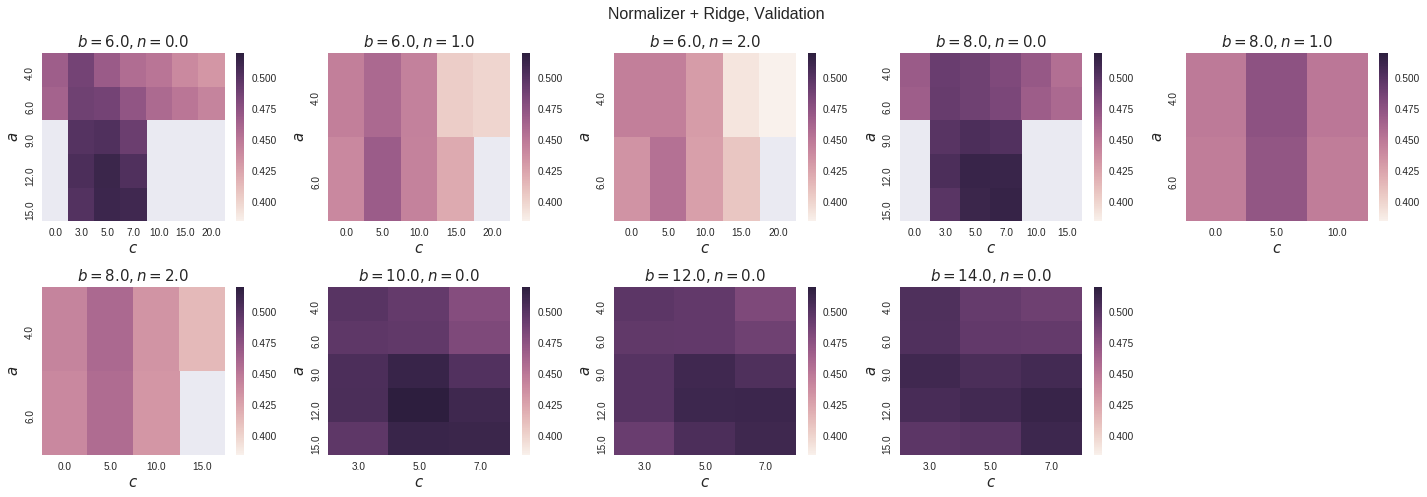

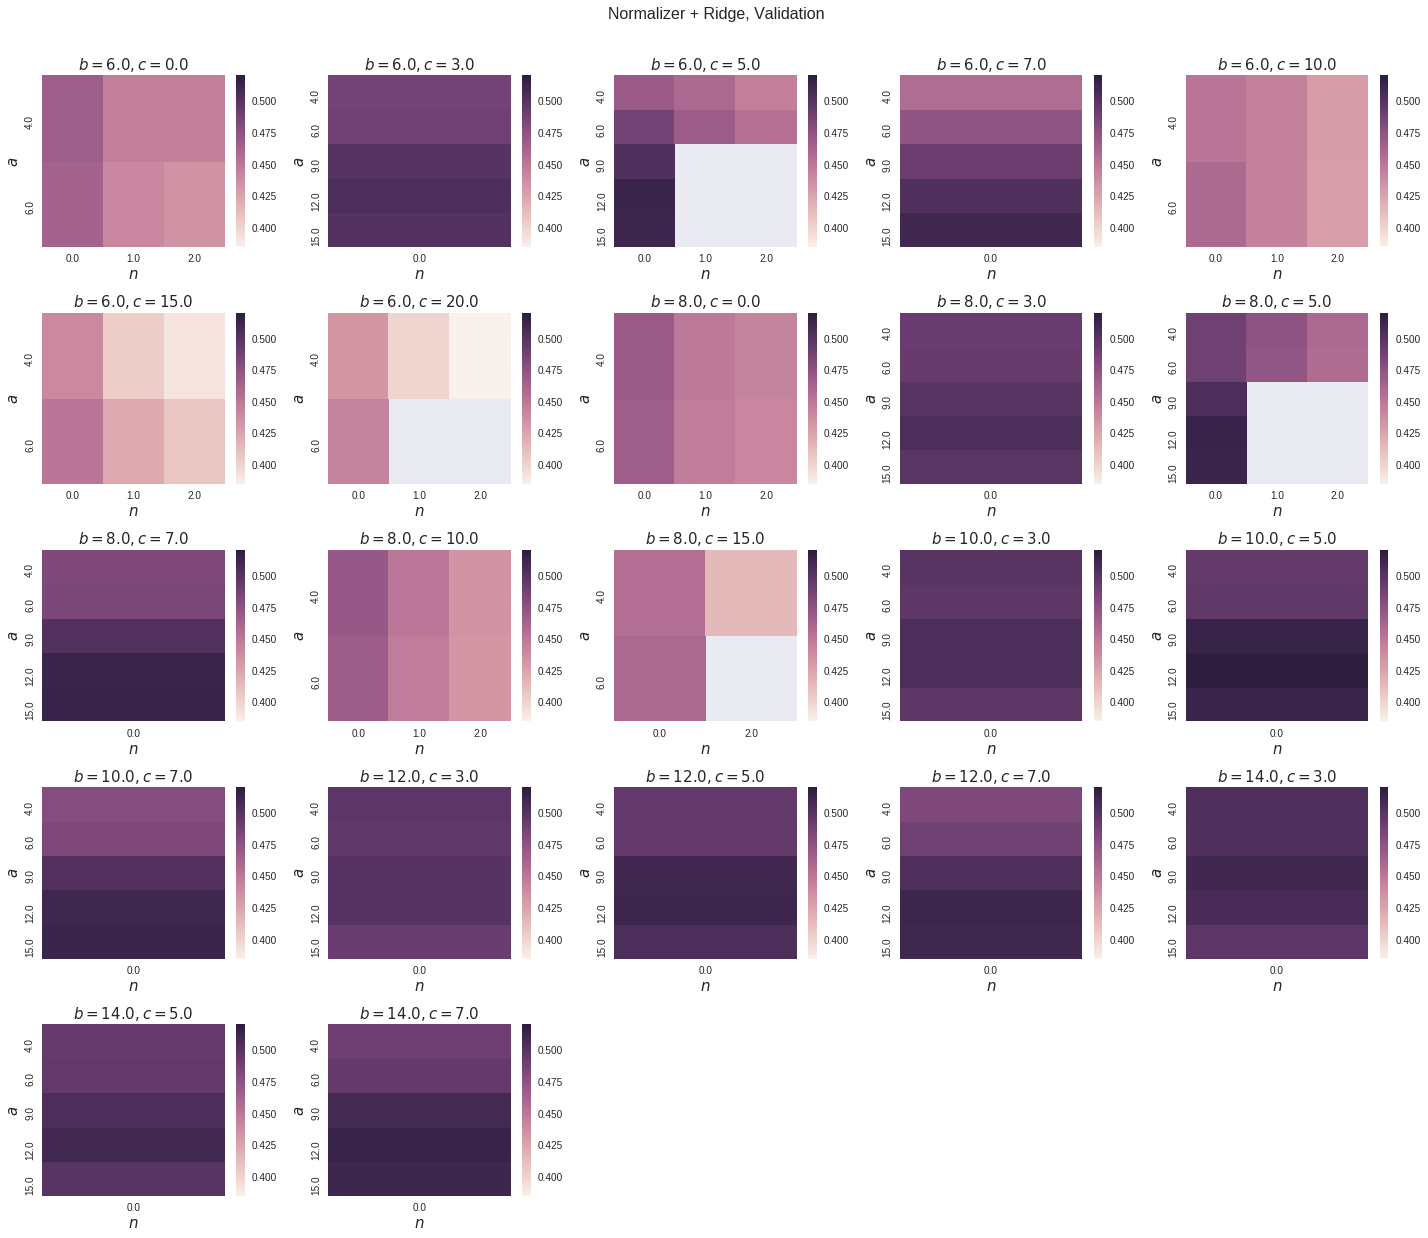

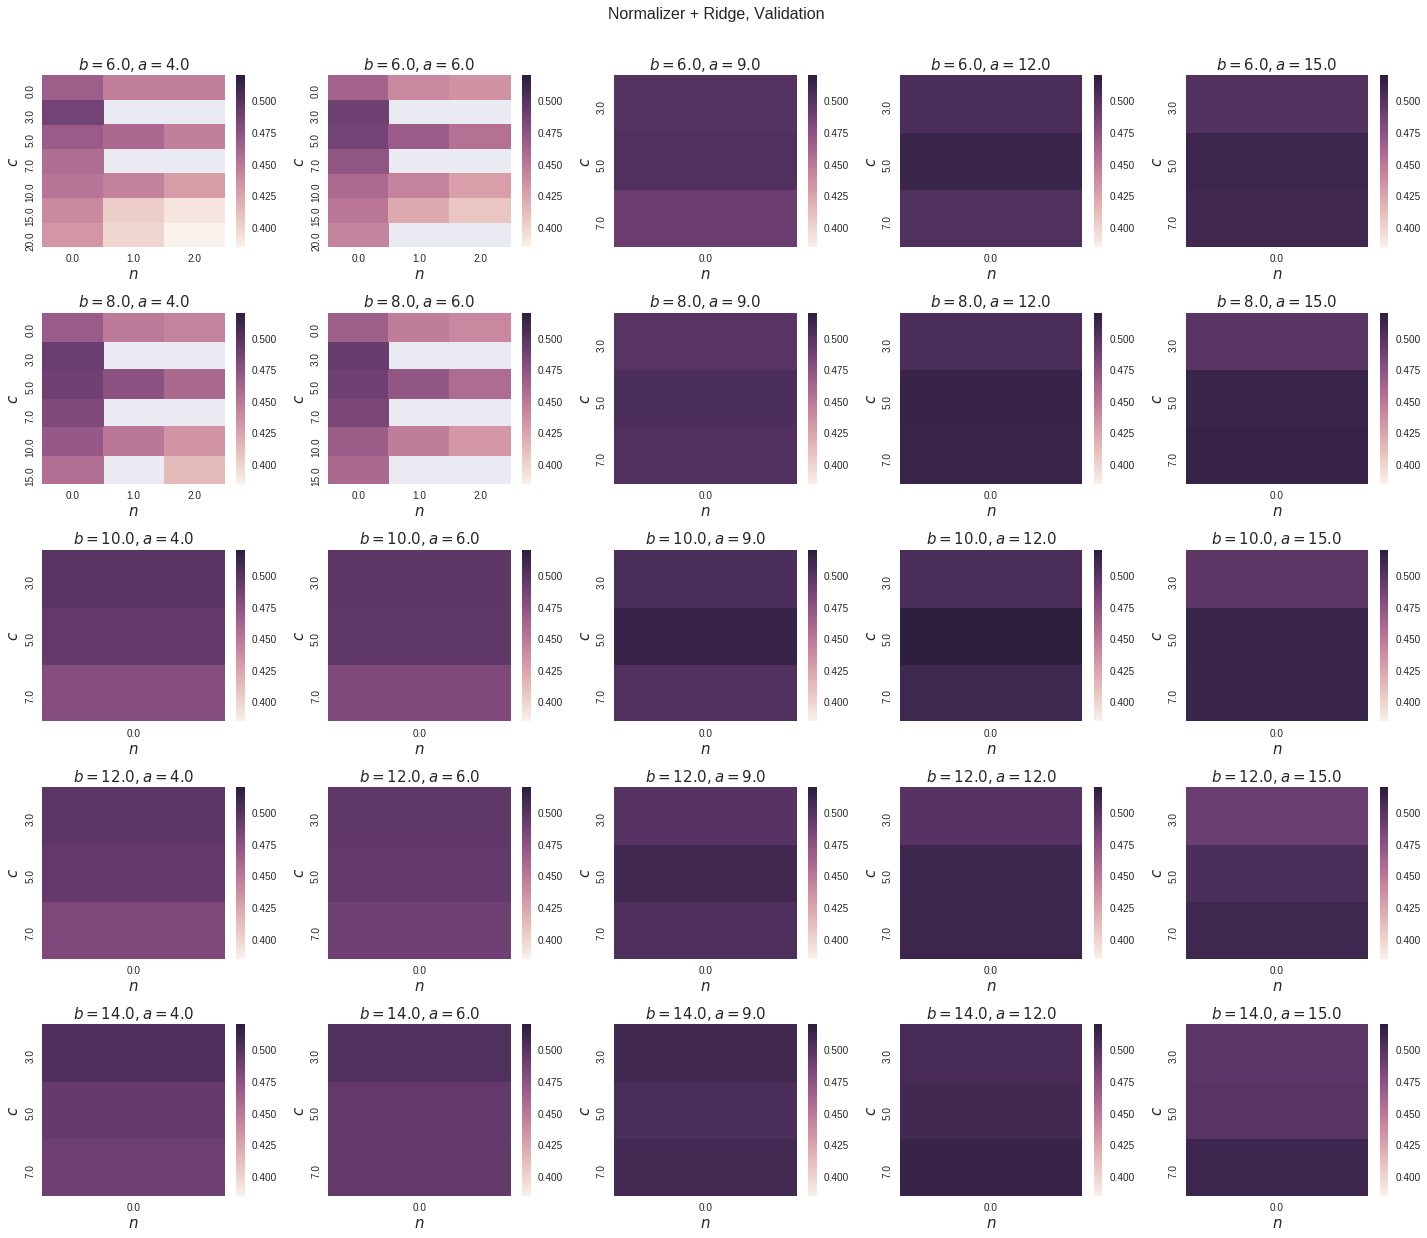

The best:
*residues-d4-b10-a12-c5-n0--skip_errors.mat


RMSD   TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    87.9381    80.6637       77.885      80.4646   
Top 1                    0.0265487  0.0176991    0.0353982    0.0176991   
Top 5                     0.106195  0.0752212      0.10177    0.0840708   
Mean score for top 1       7.36837   0.579313     0.481428     0.513763   
Mean loss score           -4.74177   0.133292      0.12786     0.126414   
Mean Pearson              0.536121  -0.556681    -0.575089    -0.575526   
Mean Spearman             0.466159  -0.442438    -0.468589    -0.465058   
Mean Kendall tau          0.329647  -0.314659    -0.332974    -0.330819   
PMCC                      0.454007  -0.642534    -0.667393    -0.676664   
SMCC                      0.658446  -0.655735    -0.680766    -0.683464   
wmPMCC                    0.575019  -0.614841    -0.627872    -0.631114   
wmSMCC                    0.485363  -0.467967    -0.492726     -0.48976   
Mean Z-score             -0.544932   0.376673     0.493414     0.423686   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      77.7389        246.712            76.5088   
Top 1                      0.0176991              0          0.0353982   
Top 5                      0.0840708              0          0.0929204   
Mean score for top 1        0.371982        7.36837            0.60733   
Mean loss score             0.104441        56.4667           0.146979   
Mean Pearson                  -0.578       0.536121          -0.628813   
Mean Spearman              -0.474732       0.466157          -0.529102   
Mean Kendall tau           -0.337395       0.329685          -0.379263   
PMCC                       -0.668768       0.454007           -0.65611   
SMCC                       -0.678357       0.658447           -0.67099   
wmPMCC                      -0.63033       0.575019          -0.674357   
wmSMCC                     -0.499484        0.48535          -0.550578   
Mean Z-score                0.494987      -0.544932           0.662418   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                80.8186                77.4469   
Top 1                                0.0309735              0.0176991   
Top 5                                 0.106195               0.106195   
Mean score for top 1                  0.514684                0.55143   
Mean loss score                       0.218123               0.207419   
Mean Pearson                         -0.611229               -0.62397   
Mean Spearman                        -0.528355              -0.537833   
Mean Kendall tau                     -0.378727              -0.386194   
PMCC                                  -0.67998              -0.693273   
SMCC                                 -0.695188              -0.701052   
wmPMCC                               -0.659157              -0.671739   
wmSMCC                               -0.550922              -0.560026   
Mean Z-score                          0.775034               0.739507   

                        GDT-HA-score-backwards  
Mean rank of the native                78.3805  
Top 1                                0.0221239  
Top 5                                0.0973451  
Mean score for top 1                  0.399551  
Mean loss score                       0.203803  
Mean Pearson                         -0.606368  
Mean Spearman                        -0.532368  
Mean Kendall tau                     -0.381632  
PMCC                                 -0.681676  
SMCC                                 -0.693697  
wmPMCC                               -0.654743  
wmSMCC                                -0.55548  
Mean Z-score                          0.779635

In [189]:
plot_results(results_val,
             'Normalizer + Ridge', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

#### Feature normalization

##### Mean score for top 1

plot_results(results_val,
             'MaxAbsScaler + Ridge', mean_top1_score,
             params, info='Validation', num_cols=2, figsize=1)

##### Correlation score

plot_results(results_val,
             'MaxAbsScaler + Ridge', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

## Backup

In [10]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

### Save dump

In [190]:
if len(results_train) == 0:
    raise Exception('Empty results')
joblib.dump((results_train, results_val), theNotebook + '.pkl')

['benchmark_residues.pkl']

### Load from dump

In [11]:
results_train, results_val = joblib.load(theNotebook + '.pkl')